In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [4]:
# Load your CSV data into a pandas DataFrame
df = pd.read_csv('../../../data/processed/tokenized_data_sample_with_custom_stopwords.csv')

# Load the vectorized features from the .npy file
vectorized_features = np.load('../../../data/processed/sample_vectorized_features_with_custom_stopwords_word2vec.npy')

feature_vectors = pd.DataFrame(vectorized_features)


feature_vectors.columns = [f'vec_feature_{i}' for i in range(feature_vectors.shape[1])]

X = feature_vectors # Feature vector
y = df['overall'] - 1  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=5, random_state=42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.58      0.47      0.52      1236
         1.0       0.56      0.25      0.34       759
         2.0       0.45      0.33      0.38      1082
         3.0       0.51      0.37      0.43      1669
         4.0       0.71      0.90      0.79      5254

    accuracy                           0.65     10000
   macro avg       0.56      0.46      0.49     10000
weighted avg       0.62      0.65      0.62     10000



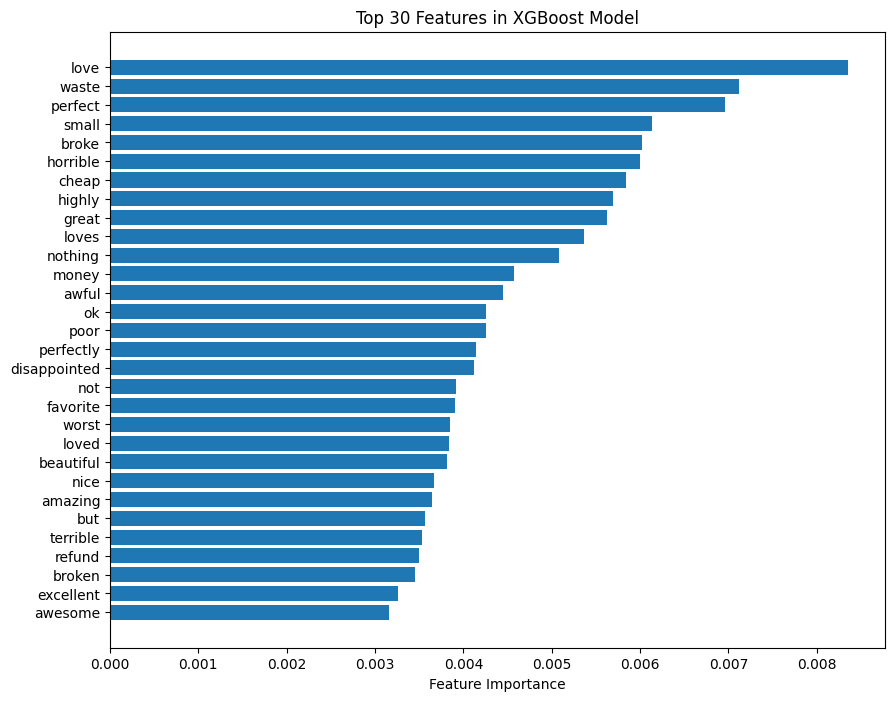

In [ ]:
feature_names = vectorizer.get_feature_names_out()

# Get the feature importances from the XGBoost model
importances = xgb_model.feature_importances_

# Create a list of (feature_name, importance) tuples
features_importances = zip(feature_names, importances)

# Sort the features by their importance
sorted_features = sorted(features_importances, key=lambda x: -abs(x[1]))

# Select the top 30 features
top_features = sorted_features[:30]

# Separate the feature names and their importances
top_feature_names, top_importances = zip(*top_features)

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_importances)), top_importances, align='center')
plt.yticks(range(len(top_importances)), top_feature_names)
plt.xlabel('Feature Importance')
plt.title('Top 30 Features in XGBoost Model')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest value on top
plt.show()


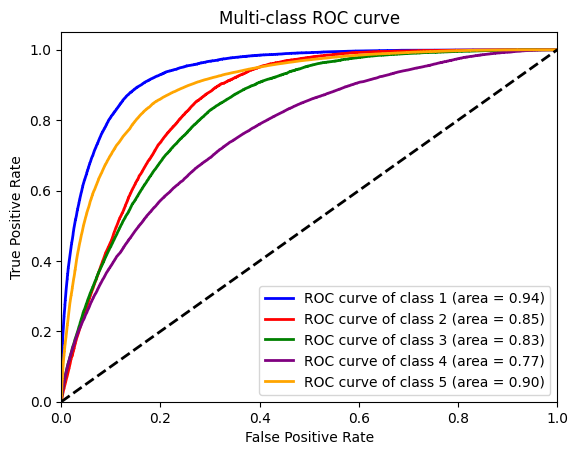

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output labels for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

# Calculate dummies once
y_pred_proba = xgb_model.predict_proba(X_test)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()

colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.show()